# Variational Autoencoders - Aula Prática

## Configurações

Importando módulos necessários

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torchsummary import summary

## Introdução

Variational Autoencoders (VAEs) são uma classe de modelos generativos que são treinados para representar dados de entrada em um espaço latente de baixa dimensão. Eles são baseados em redes neurais e são treinados usando métodos de inferência variacional. VAEs são uma extensão de autoencoders tradicionais, que são usados para aprender representações compactas de dados de entrada. A principal diferença entre VAEs e autoencoders tradicionais é que VAEs são treinados para aprender a distribuição de probabilidade dos dados de entrada, enquanto autoencoders tradicionais são treinados para aprender uma função de mapeamento determinística dos dados de entrada para um espaço latente.

Nessa aula prática, vamos implementar um Variational Autoencoder para reconstruir imagens do dataset MNIST.

## Dataset

Vamos começar carregando o dataset MNIST. O dataset é composto por imagens de dígitos escritos à mão, com dimensões 28x28 pixels.

In [ ]:
mnist_path = '/pgeoprj2/ciag2024/dados'

In [ ]:
"""
Como queremos que o autoencoder aprenda a reconstruir a imagem de entrada,
reformulamos o dataset MNIST para que ele retorne a mesma imagem como entrada e saída.
"""
class AutoencoderMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, input_transform=None, target_transform=None, download=False, return_labels=False):
        self.dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.return_labels = return_labels

    def __getitem__(self, idx):
        x, label = self.dataset[idx]
        y = x.clone()

        if self.input_transform:
            x = self.input_transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return (x, y, label) if self.return_labels else (x, y)
    
    def start_return_labels(self):
        self.return_labels = True
    
    def stop_return_labels(self):
        self.return_labels = False

    def __len__(self):
        return len(self.dataset)

In [ ]:
mnist_train_ds = AutoencoderMNIST(
    mnist_path,
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    return_labels=True
)
mnist_test_ds = AutoencoderMNIST(
    mnist_path,
    train=False,
    transform=transforms.ToTensor()
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)

In [ ]:
# Plot the first 16 images from the MNIST dataset
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i == 0:
        print(f"image shape: {mnist_train_ds[i][0].shape}")
    image, _, label = mnist_train_ds[i]
    ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Modelo

Como já mencionado, um VAE é composto por duas partes principais: um encoder e um decoder. O encoder é uma rede neural que mapeia os dados de entrada para um espaço latente de baixa dimensão, enquanto o decoder é uma rede neural que mapeia os pontos no espaço latente de volta para o espaço de entrada.

O principal da arquitetura já vimos na aula sobre Autoencoders tradicionais, mas a diferença é que o encoder de um VAE mapeia os dados de entrada para uma distribuição de probabilidade no espaço latente, em vez de mapear os dados de entrada para um ponto específico no espaço latente, como podemos ver na imagem abaixo:

O encder vai transformar os dados em $ \mu $ e $ \sigma $, que são os parâmetros da distribuição normal que representa o espaço latente, seguindo a fórmula:

$$ 
z = \mu + \sigma \cdot \epsilon 
$$

com $ \epsilon $ sendo uma amostra de uma distribuição normal padrão.

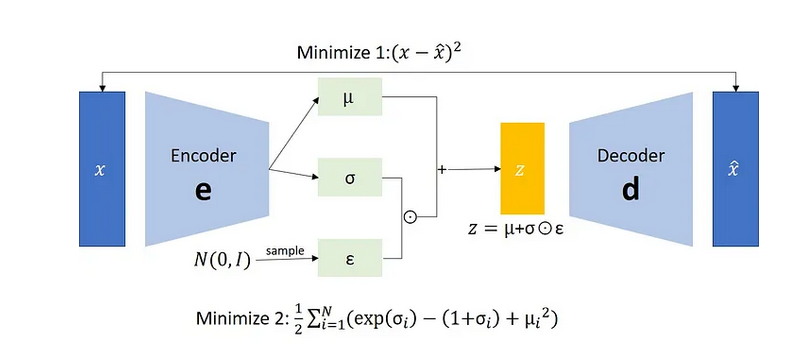

In [59]:
class VariationalConvolutionalEncoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(VariationalConvolutionalEncoder, self).__init__()
        self.latent_size = latent_size

        # reduzimos o tamanho da imagem
        # considerando input (n_channels, 28, 28)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 16, 3, padding=1),  # (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (16, 14, 14)
            nn.Conv2d(16, 8, 3, padding=1),  # (8, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (8, 7, 7)
            nn.Conv2d(8, 2, 3, padding=1),  # (2, 7, 7)
            nn.ReLU(),
        )

        # extraimos as features da imagem reduzida
        self.flatten = nn.Flatten()  # (2 * 7 * 7,) = (98,)

        # finalmente fazemos o encoding da nossa imagem em um vetor n dimensional
        self.z_log_sigma = nn.Linear(98, self.latent_size)
        self.z_mean = nn.Linear(98, self.latent_size)

    @property
    def device(self):
        return next(self.parameters()).device

    # função para amostrar a representação latente a partir da média e desvio padrão
    def sample(self, z_mean, z_log_sigma):
        epsilon = torch.normal(0, 0.1, z_mean.shape, device=self.device)
        return z_mean + torch.exp(z_log_sigma) * epsilon
    
    # função para calcular a divergência KL para a loss
    def kl_divergence(self):
        return -0.5 * torch.sum(1 + self.stdev - self.mean.pow(2) - self.stdev.exp())

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)

        # salvamos os valores de média e desvio padrão para serem usados na loss
        self.stdev = self.z_log_sigma(x)
        self.mean = self.z_mean(x)

        x = self.sample(self.mean, self.stdev)

        return x

In [60]:
# O decoder do VAE é o mesmo que o do AE
class ConvolutionalDecoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(ConvolutionalDecoder, self).__init__()
        self.latent_size = latent_size

        # decodificamos a representação latente para uma imagem 7x7
        self.decoder = nn.Linear(self.latent_size, 98)
        self.unflatten = nn.Unflatten(1, (2, 7, 7)) # (2, 7, 7)

        # voltamos a imagem ao tamanho original
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 8, 3, padding=1), # (8, 7, 7)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (8, 14, 14)
            nn.Conv2d(8, 16, 3, padding=1), # (16, 14, 14)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (16, 28, 28)
            nn.Conv2d(16, n_channels, 3, padding=1), # (n_channels, 28, 28)
            nn.Sigmoid(), # sigmoid na última camada para que o output esteja no intervalo [0, 1]
        )

    def forward(self, x):
        x = self.decoder(x)
        x = self.unflatten(x)
        x = self.conv_layers(x)
        return x

In [61]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalConvolutionalEncoder(latent_size, n_channels)
        self.decoder = ConvolutionalDecoder(latent_size, n_channels)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(latent_size=2, n_channels=1)
vae = vae.to(device)
summary(vae, (1, 28, 28))

## Treinando o modelo

Vamos treinar o modelo para reconstruir imagens do dataset MNIST. O modelo será treinado por 20 épocas, com batch size 128 e otimizador Adam.

In [66]:
def loss_to_string(loss, prefix):
    return ' '.join([f'{prefix}_{l}: {loss[l]:.4f}' for l in loss])

def train(model, optimizer, loss_fn, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = {'loss': 0.0}

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            rec_loss = loss_fn(outputs, targets)
            rec_loss /= inputs.size(0)
            train_losses['rec_loss'] = train_losses.get('rec_loss', 0.0) + rec_loss.item()

            # Adicionamos a divergência KL à loss
            kl_loss = model.encoder.kl_divergence()
            kl_loss /= inputs.size(0)
            train_losses['kl_loss'] = train_losses.get('kl_loss', 0.0) + kl_loss.item()

            loss = rec_loss + kl_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_losses['loss'] += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_losses['loss']/(i+1):.4f}")

        for l in train_losses:
            train_losses[l] /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_losses = {'loss': 0.0}

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = model(inputs)
                    rec_loss = loss_fn(outputs, targets)
                    rec_loss /= inputs.size(0)
                    val_losses['rec_loss'] = val_losses.get('rec_loss', 0.0) + rec_loss.item()

                    kl_loss = model.encoder.kl_divergence()
                    kl_loss /= inputs.size(0)
                    val_losses['kl_loss'] = val_losses.get('kl_loss', 0.0) + kl_loss.item()

                    loss = rec_loss + kl_loss

                    val_losses['loss'] += loss.item()

            for l in val_losses:
                val_losses[l] /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(train_losses, 'train')} | {loss_to_string(val_losses, 'val')}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(train_losses, 'train')}")

In [95]:
vae = VariationalAutoencoder(latent_size=2, n_channels=1)

In [96]:
mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

In [ ]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

## Analisando os resultados

Nessa etapa, vamos analisar os resultados obtidos pelo autoencoder. Vamos visualizar as imagens de entrada e as imagens reconstruídas pelo autoencoder. Além disso, vamos visualizar a representação dos dados no espaço latente.

In [ ]:
# Get some images from the test dataset
data_iter = iter(test_dl)
images, _ = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
vae.eval()
with torch.no_grad():
    reconstructions = vae(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(12, 5))

for i in range(8):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    # Reconstructed images
    ax = axes[1, i]
    ax.imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images')

    loss = criterion(reconstructions[i], images[i])
    print(f"Loss for image {i+1}: {loss.item()}")

plt.tight_layout()
plt.show()

In [ ]:
# Get the latent representations for all test data
latent_representations = []
labels_agg = []
digits = list(range(10))

mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(mnist_test_ds, batch_size=128)

vae.eval()
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = vae.encoder(images)
        latent_representations.append(latent_vectors.cpu().numpy())
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations = np.concatenate(latent_representations, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('jet', 10)
for d in digits:
    indices = np.where(labels_agg == d)
    plt.scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{d}",
        c=[cmap(d)],
        alpha=0.5,
    )
# add the labels mapping
plt.legend(markerscale=5)
plt.title('Latent Representations of Test Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

É interessante observar na distribuição dos dados no em comparação com com o observado no resultado do Autoencoder tradicional é que o Autoencoder Variacional distribui os dados no espaço latente tentando seguir uma distribuição normal padrão.

# Exercícios

## Exercício 1

Teste o autoencoder variacional com mais dimensionalidades no espaço latente. Tente com 5, 20 e 50 dimensões. Compare os resultados obtidos.

<details>
<summary>Dica:</summary>

Para visualizar a representação dos dados no espaço latente, utilize um [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) para reduzir a dimensionalidade dos dados para 2 dimensões.

</details>

## Exercício 2

Teste o autoencoder variacional no dataset Fashion MNIST. Compare os resultados obtidos com o dataset MNIST. Teste com diferentes dimensionalidades no espaço latente e tente encontrar a menor dimensionalidade que ainda consegue reconstruir as imagens de forma satisfatória.

<details>
<summary>Dica:</summary>

O autoencoder fornecido talvez seja muito simples para o dataset Fashion MNIST. Tente aumentar a complexidade do modelo.

</details>

In [ ]:
faishon_mnist_path = '/pgeoprj2/ciag2024/dados'